In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw
import numpy as np
import pickle
from torchvision.transforms import ToTensor

In [2]:
# always square image
image_res = 64

# True    --->   train the network (depends on currently_train_on)
# False   --->   preload the desired network from .PTH (depends on currently_train_on)
train_or_load = False

# (this variable also decides what model to load if train_or_load is set to False)
# 0   --->   real images (COCO VAL SET 2014)
# 1   --->   type A noise (torch.rand)
# 2   --->   type B noise (random colors, rectangles and a little of type A noise)
currently_train_on = 2

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.linear_mid1 = nn.Linear(image_res * image_res * 3, 2048)
        self.linear_mid2 = nn.Linear(2048, 1024)
        self.linear_mid3 = nn.Linear(1024, 2048)
        self.linear_mid4 = nn.Linear(2048, image_res * image_res * 3)

    def forward(self, x):
        save_shape = x.shape
        x = torch.flatten(x, start_dim=1)
        
        x = self.linear_mid1(x)
        x = self.linear_mid2(x)
        x = self.linear_mid3(x)
        x = self.linear_mid4(x)
        
        x = x.view(save_shape)
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (linear_mid1): Linear(in_features=12288, out_features=2048, bias=True)
  (linear_mid2): Linear(in_features=2048, out_features=1024, bias=True)
  (linear_mid3): Linear(in_features=1024, out_features=2048, bias=True)
  (linear_mid4): Linear(in_features=2048, out_features=12288, bias=True)
)

In [4]:
loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [5]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res, image_res))

    if img.mode != 'RGB':
        img = img.convert('RGB')

    img_array = np.array(img) / 255

    return torch.tensor(img_array, dtype=torch.float32, device=GPU)

In [6]:
def display_image(img_array):
    img_array = np.array(img_array)
    plt.imshow(img_array)
    plt.show()

In [7]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

In [8]:
class RealImageDataset():
    def __init__(self, path):
        self.fnames = os.listdir(path)
        self.images = []
        
        for x in tqdm(self.fnames):
            self.images.append(load_image(f"{path}/{x}"))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

In [9]:
class TypeANoiseImageDataset():
    def __init__(self, amount):
        self.images = []
        
        for x in tqdm(range(amount)):
            self.images.append(torch.rand((image_res, image_res, 3), device=GPU))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

In [10]:
class TypeBNoiseImageDataset(Dataset):
    def generate_random_rectangles(self):
        background_color = tuple(np.random.randint(0, 256, size=3))
        img = Image.new('RGB', (image_res, image_res), color=background_color)

        draw = ImageDraw.Draw(img)
        for i in range(30):
            x = np.random.randint(0, image_res)
            y = np.random.randint(0, image_res)
            width = np.random.randint(1, 20)
            height = np.random.randint(1, 20)
            color = tuple(np.random.randint(0, 256, size=3))
            draw.rectangle((x, y, x+width, y+height), fill=color)

        arr = torch.tensor(np.array(img), dtype=torch.float32, device=GPU) / 255

        return arr
    
    def __init__(self, amount):
        self.images = []
        
        for x in tqdm(range(amount)):
            self.images.append(self.generate_random_rectangles())

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

In [11]:
if currently_train_on == 0:
    if train_or_load:
        real_dataset = RealImageDataset(r"!!!CHANGE THIS PATH TO WHEREVER THE FOLDER WITH IMAGES IS LOCATED!!! example: c:/goofy/ahh/path/val2014")
        real_loader = DataLoader(real_dataset, batch_size=1000, shuffle=True)
    else:
        state_dict = torch.load(r"./real_images_autoencoder_[really nice performance].pth")
        net.load_state_dict(state_dict)

In [12]:
if currently_train_on == 1:
    if train_or_load:
        Anoise_dataset = TypeANoiseImageDataset(40000)
        Anoise_loader = DataLoader(Anoise_dataset, batch_size=1000, shuffle=True)
    else:
        state_dict = torch.load(r"./typeA_images_autoencoder_[really not nice performance].pth")
        net.load_state_dict(state_dict)

In [13]:
if currently_train_on == 2:
    if train_or_load:
        Bnoise_dataset = TypeBNoiseImageDataset(amount=40000)
        Bnoise_loader = DataLoader(Bnoise_dataset, batch_size=1000, shuffle=True)
    else:
        state_dict = torch.load(r"./typeB_images_autoencoder_[really nice performance].pth")
        net.load_state_dict(state_dict)

In [14]:
if train_or_load:
    loss_list = []

    for epoch in tqdm(range(3000)):
        for x in enumerate(Anoise_loader):
            loss_list.append(train_nn(x[1].permute(0, 3, 2, 1), x[1].permute(0, 3, 2, 1), net))
else:
    print("did not train because a model was laoded (can be changed by setting train_or_load to false)")

did not train because a model was laoded (can be changed by setting train_or_load to false)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


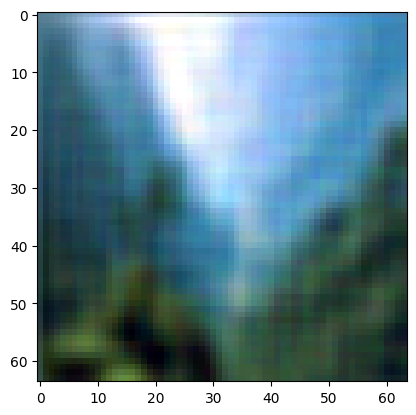

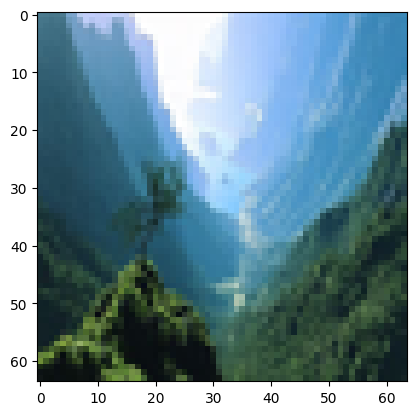

In [21]:
display_image(net(torch.unsqueeze(load_image(r"C:\Users\user\Desktop\AUTOENCODER\R1\any_image_dataset\real world images\th-3274577047.jpg"), 0).permute(0, 3, 2, 1)).permute(0, 3, 2, 1)[0].detach().cpu())
display_image(load_image(r"C:\Users\user\Desktop\AUTOENCODER\R1\any_image_dataset\real world images\th-3274577047.jpg").detach().cpu())

In [21]:
for x in tqdm(range(10)):
    image = Bnoise_dataset[x].detach().cpu()  # Assuming Anoise_dataset[x] is a tensor

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Save the figure with indexed filename
    filename = f"BnoidseImage{x}.png"
    plt.savefig(filename)

    # Close the figure to release memory
    plt.close(fig)

100%|██████████| 10/10 [00:00<00:00, 13.30it/s]


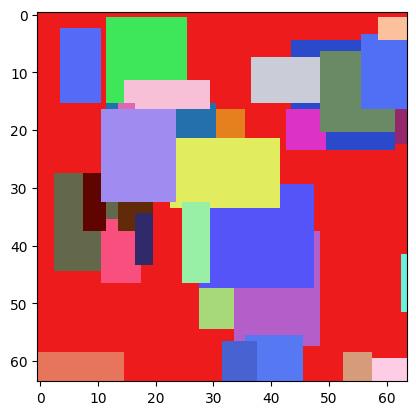

In [20]:
display_image(Bnoise_dataset[1].detach().cpu())